In [1]:
#-*-coding:utf-8-*-

%load_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torchvision

import cv2

import copy

import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import date2num
%matplotlib inline

__ROOT_PATH = os.path.abspath('../../')
sys.path.append(__ROOT_PATH)

matplotlib.rcParams['figure.facecolor'] = 'w'

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [3]:
from scgan.loader.beautygan_loader import BeautyganDataset
from scgan.model.scseparator_model import SCSeparatorBeautyganModel

In [4]:
#DATA_ROOT = os.path.join(__ROOT_PATH, "data/")
DATA_ROOT = "/data/"
RUN_ROOT = os.path.join(__ROOT_PATH, "runs/")

In [5]:
run_dir = os.path.join(RUN_ROOT, "beautygan_sc_separate/")
os.makedirs(run_dir, exist_ok=True)

params = {'seed': 2222, 'num_epoch': 200, 'batch_size': 8, 'test_batch_size': 512,
          'learning_rate': 0.0001, 'scheduler_gamma': 0.98, 'weight_decay': 0.00001,# 'clip_size': 3.,
          'lambda_identity': 1., 'lambda_cycle': 1., 'lambda_weight_cycle': 1., 'lambda_siamese': 1.,
          'lambda_content': 0.1, 'lambda_style': 0., 'lambda_content_seg': 0., 'lambda_style_seg': 0., 'lambda_source': 0.01, 'lambda_reference': 0.01,
          'gamma_content': 1., 'gamma_style': 1., 'gamma_content_seg': 1., 'gamma_style_seg': 1., 'gamma_source': 1., 'gamma_reference': 1.,
          'scheduler_interval': 1000, 'checkpoint_interval': 10,
          'validation_interval': 10, 'logging_interval': 10, 'sampling_interval': 100,
          'stopping_loss': 'loss',
          'run_dir': run_dir}

In [6]:
train_dataset = BeautyganDataset(root=DATA_ROOT, image_size=256, seg_size=64)
print(len(train_dataset))

2718


90


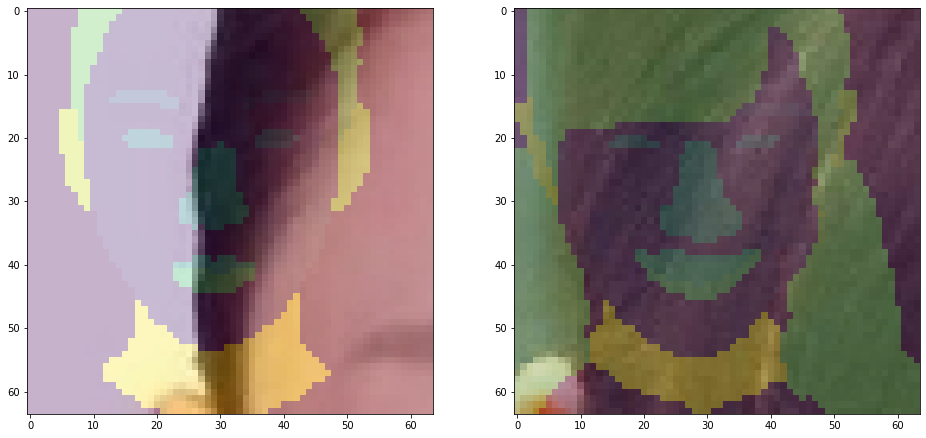

In [7]:
dataset = train_dataset
index = np.random.randint(len(dataset))

print(index)
data = dataset[index]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(data['x1'][:3].numpy().transpose(1, 2, 0))
plt.imshow(data['seg1'].numpy(), alpha=0.3)
ax = fig.add_subplot(1, 2, 2)
plt.imshow(data['x2'][:3].numpy().transpose(1, 2, 0))
plt.imshow(data['seg2'].numpy(), alpha=0.3)
plt.show()

In [8]:
train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True, drop_last=True)
print(len(train_loader))

339


In [9]:
# 차이점: 이거는 s1, 0 전부 쓴거 (옆에거는 0만씀)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sc_model = SCSeparatorBeautyganModel(device)
#sc_model.load(os.path.join(run_dir, 'best_model.pth.tar'))
sc_model.train_model(train_loader, params=params)


Learning with learning rate:  0.00010000.

[1/200] 10'th step. [LOSS] 2.123170. [LOSS_IDENTITY] 0.303337. [LOSS_CYCLE] 0.410289. [LOSS_WEIGHT_CYCLE] 1.147865. [LOSS_CONTENT] -0.005998. [ACCURACY_CONTENT] 0.500000. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.562500. [LOSS_SIAMESE] 0.277439. [NORM_S1] 0.662855. [NORM_S2] 0.660220. [LOSS_SOURCE] -0.004872. [ACCURACY_SOURCE] 0.687500. [LOSS_REFERENCE] -0.004890. [ACCURACY_REFERENCE] 0.687500. [LOSS_CONTENT_SEG] 0.000000. [ACCURACY_CONTENT_SEG] 0.054886. [LOSS_STYLE_SEG] 0.000000. [ACCURACY_STYLE_SEG] 0.108871
    Best Step:     10. Elapsed Time: 19.115194 seconds.
[1/200] 20'th step. [LOSS] 1.632949. [LOSS_IDENTITY] 0.208986. [LOSS_CYCLE] 0.290679. [LOSS_WEIGHT_CYCLE] 0.957504. [LOSS_CONTENT] -0.061200. [ACCURACY_CONTENT] 0.625000. [LOSS_STYLE] 0.000000. [ACCURACY_STYLE] 0.500000. [LOSS_SIAMESE] 0.264221. [NORM_S1] 0.625587. [NORM_S2] 0.629851. [LOSS_SOURCE] -0.016271. [ACCURACY_SOURCE] 0.937500. [LOSS_REFERENCE] -0.010970. [ACCURACY_REFERE

In [ ]:
all_input, all_output = sc_model.predict(test_loader)

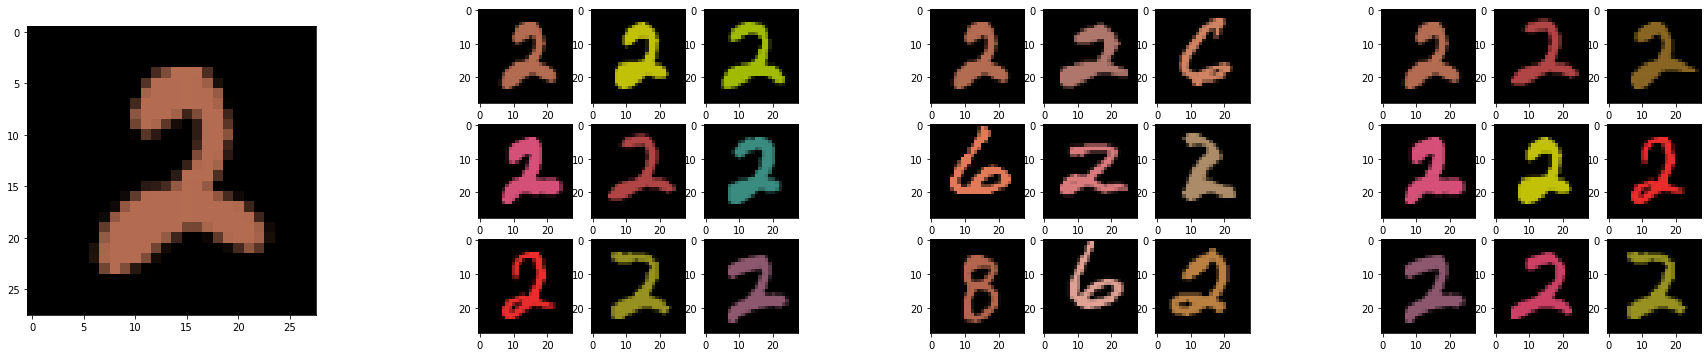

In [14]:
images = all_input['x2'].numpy().transpose(0, 2, 3, 1)
latents = all_output['z2'].numpy()
styles = all_output['s2'].numpy()
contents = all_output['c2'].numpy()

index = np.random.randint(len(images))

fig = plt.figure(figsize=(30, 6))

ax = fig.add_subplot(1, 5, 1)
ax.imshow(images[index])
content_indices = ((contents-contents[index:index+1])**2).mean(axis=1).argsort(axis=0)
style_indices = ((styles-styles[index:index+1])**2).mean(axis=1).argsort(axis=0)
latent_indices = ((latents-latents[index:index+1])**2).mean(axis=1).argsort(axis=0)
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+5)
    ax.imshow(images[content_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+9)
    ax.imshow(images[style_indices[i]])
for i in range(9):
    ax = fig.add_subplot(3, 15, 15*(i//3)+(i%3)+13)
    ax.imshow(images[latent_indices[i]])

plt.savefig(os.path.join(__ROOT_PATH, "./results/", f"similar_test.png"), dpi=200, bbox_inches='tight')
plt.show()